<a href="https://colab.research.google.com/github/aryachandrak/Machine-Learning-2024-Ganjil/blob/main/Jobsheet4/Praktikum5_Klasifikasi_Citra_Siang_dan_Malam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Langkah 0 - Import Library

In [1]:
# Import Required Libraries
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import pandas as pd

Lakukan ekstraksi data gambar, kemudian definisikan lokasi gambar. Pada contoh ini, folder gambar berlokasi sama dengan lokasi file python

In [6]:
# Image directories
train_dir = "/content/drive/MyDrive/images/training/"
test_dir = "/content/drive/MyDrive/images/test/"

#Langkah 1 - Load Data dan Visualisasikan

Buatlah fungsi untuk membuat daftar seluruh path dari gambar.

In [7]:
def load_dataset(img_dir):
    p = Path(img_dir)
    dirs = p.glob('*')

    img_list = []

    for dir in dirs:
        label = str(dir).split('/')[-1]
        for file in dir.glob('*.jpg'):
            img = mpimg.imread(file)

            if not img is None:
                img_list.append((img, label))

    return img_list

Load gambar training

In [8]:
# Load training data
train_img = load_dataset(train_dir)

Lakukan pengecekan pada salah satu data pada list. List harus berisi tuple dengan dua data, yaitu data gambar dan label dari gambar.

In [9]:
# Check the first data
# It should be a tuple consist of arrays of image and image labels
train_img[0]

(array([[[32, 19, 13],
         [26, 13,  7],
         [37, 22, 15],
         ...,
         [28, 22, 10],
         [12, 13,  0],
         [ 4,  6,  0]],
 
        [[32, 19, 13],
         [28, 15,  9],
         [39, 24, 17],
         ...,
         [33, 27, 15],
         [24, 25, 11],
         [17, 19,  5]],
 
        [[35, 22, 16],
         [33, 20, 14],
         [43, 28, 21],
         ...,
         [27, 21,  9],
         [21, 22,  8],
         [12, 14,  0]],
 
        ...,
 
        [[31, 20, 18],
         [16,  5,  3],
         [20,  9,  7],
         ...,
         [ 1,  2,  0],
         [ 8, 10,  5],
         [ 2,  4,  0]],
 
        [[29, 18, 16],
         [ 8,  0,  0],
         [12,  1,  0],
         ...,
         [14, 15, 10],
         [37, 39, 34],
         [41, 43, 38]],
 
        [[22, 11,  9],
         [23, 12, 10],
         [33, 22, 20],
         ...,
         [13, 14,  9],
         [20, 22, 17],
         [ 5,  7,  2]]], dtype=uint8),
 'night')

Cek ukuran gambar secara acak

In [10]:
# Random size checking
pick_random = np.random.randint(0, len(train_img))

# Check img size
print(f'Image {pick_random}')
print(train_img[pick_random][0].shape)

Image 134
(737, 1024, 3)


Tampilkan gambar untuk inspeksi secara visual. Buatlah fungsi untuk membantu memvisualkan gambar

In [11]:
# Function to Visualize
def random_img_viz(img_list):
    rand_num = np.random.randint(0, len(img_list))

    img = img_list[rand_num][0]
    label = img_list[rand_num][1]
    label_str = 'day' if label == 1 else 'night'

    plt.imshow(img)
    print(f'Shape\t: {img.shape}')
    print(f'Label\t: {label}')

Lakukan visualisasi gambar secara acak

Shape	: (469, 640, 3)
Label	: night


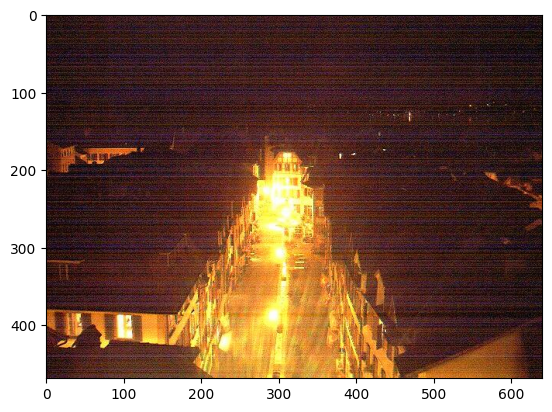

In [12]:
random_img_viz(train_img)

#Langkah 3 - Pra Pengolahan Data

Pada tahap ini, kita akan melakukan dua proses utama, yaitu standardisasi ukuran gambar, dan encoding label gambar.

Bualah fungsi berikut untuk menstandarkan ukuran gambar

In [13]:
def standarized_input(image):
    # resize to w: 1100, h:600
    std_img = cv2.resize(image, (1100,600))

    return std_img

Selanjutnya, buatlah fungsi untuk kebutuhan encoding label

In [14]:
def label_encoder(label):
    # Encode the label
    # day as 1; night as 0
    num_val = 0

    if(label == 'day'):
        num_val = 1

    return num_val

Terakhir, buatlah fungsi untuk melakukan kedua hal tersebut secara sekaligus untuk semua gambar dalam list.

In [15]:
def preprocess(img_list):
    std_img_list = []

    for item in img_list:
        image = item[0]
        label = item[1]

        # Standarized the image
        std_img = standarized_input(image)

        # Create the label
        img_label = label_encoder(label)

        std_img_list.append((std_img, img_label))

    return std_img_list

Lakukan pra pengolahan data pada data training.

In [16]:
train_std_img_list = preprocess(train_img)

Lakukan pengecekan ukuran gambar secara acak

In [17]:
# Random size checking
pick_random = np.random.randint(0, len(train_std_img_list))

# Check img size
print(f'Image {pick_random}')
print(train_std_img_list[pick_random][0].shape)

Image 75
(600, 1100, 3)


#Langkah 4 - Ekstraksi Fitur

Selanjutnya, untuk dapat membadakan antara label satu dengan label yang lain, kita memerlukan sebuah fitur. Fitur adalah penciri dari sebuah data yang dapat digunakan untuk membendakan data satu dengan yang lain. Pada percobaan kali ini, kita akan menggunakan fitur yang sederhana yaitu nilai rata-rata dari tingkat kecerahan gambar (average brightness). Namun sebelum dapat melakukan hal tersebut, kita akan mengubah ruang warna (colorspace) dari RGB menjadi HSV (Hue, Saturation, Value). Hal ini dikarenakan, tingkat kecerahan (brightness) lebih mudah didapatkan dari HSV berdasarkan nilai Valuenya.

Buatlah fungsi berikut untuk mendapatkan nilai rata-rata tingkat kecerahan

In [18]:
# Get feature based on average brightness using HSV colorspace
def avg_brightness(image):
    # Convert image to HSV
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Calculate the avg of brightness
    sum_brightness = np.sum(img_hsv[:,:,2]) # take the 3rb value which is the V channel
    area = image.shape[0] * image.shape[1]
    avg = sum_brightness / area

    return avg

Lakukan pengecekan pada gambar secara acak. INGAT! Gunakan gambar yang telah melalui proses pra pengolahan data!

Image 217
Avg Brighness: 142.5322


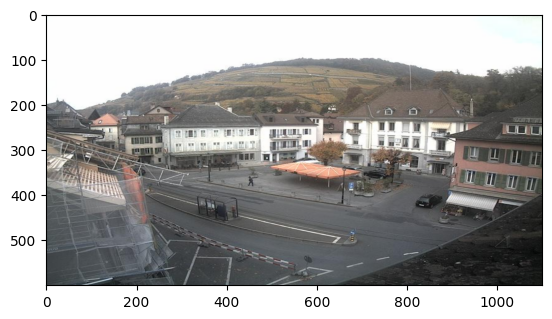

In [19]:
# Check on random image
rand_img = np.random.randint(0, len(train_std_img_list))

feature_img = train_std_img_list[rand_img][0]

avg_img = avg_brightness(feature_img)

print(f'Image {rand_img}')
print(f'Avg Brighness: {avg_img:.4f}')
plt.imshow(feature_img)

#Langkah 5 - Klasifikasi dengan Metode Threshold

Pada tahap ini, kita akan melakukan proses klasifikasi sederhana dengan menggunakan nilai ambang batas (threshold) dari nilai rata-rata kecerahan yang kita tentukan sendiri.

Buatlah fungsi berikut,

In [20]:
def predict_label(img, threshold):
    # Computer average brightness
    avg = avg_brightness(img)
    pred = 0

    # Predict the label based on user defined threshold
    if avg > threshold:
        pred = 1

    return pred

Lakukan pengecekan prediksi secara acak pada data training

Image 37
Actual label: 0
Predicted label: 0


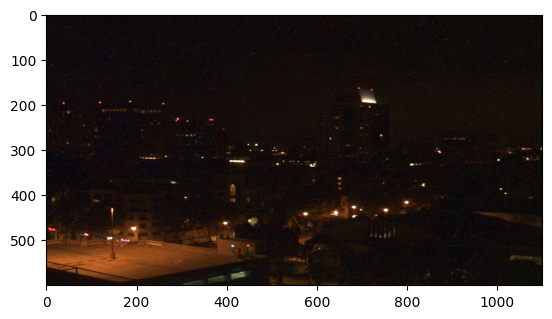

In [21]:
# Test the classifier on train data
rand_img = np.random.randint(0, len(train_std_img_list))

pred = predict_label(train_std_img_list[rand_img][0], threshold=120)

# Evaluate
print(f'Image {rand_img}')
print(f'Actual label: {train_std_img_list[rand_img][1]}')
print(f'Predicted label: {pred}')
plt.imshow(train_std_img_list[rand_img][0])

#Langkah 6 - Evaluasi (Manual)

Selanjutnya kita akan membuat fungsi evaluasi model sederhana, yaitu dengan membandingkan label yang diprediksi benar dengan seluruh data. Ingat kembali konsep confussion matrix.

Buatlah fungsi berikut,

In [22]:
def evaluate(img_list, threshold):
    miss_labels = []

    for file in img_list:
        # Get the ground truth / correct label
        img = file[0]
        label = file[1]

        # Get prediction
        pred_label = predict_label(img, threshold)

        # Compare ground truth and pred
        if pred_label != label:
            miss_labels.append((img, pred_label, label))

    total_img = len(img_list)
    corr_pred = total_img - len(miss_labels)
    accuracy = corr_pred / total_img

    print(f'Accuracy: {accuracy:.4f}')

Lakukan evaluasi pada data training dengan nilai ambang batas 120

In [23]:
# Evaluate on train data
evaluate(train_std_img_list, threshold=120)

Accuracy: 0.8417


Selanjutnya, kita akan melakukan evaluasi pada data testing. Namun sebelumnya, data testing harus diperlakukan sama dengan data training dalam konteks pra progolahan data dan ekstraksi fitur.

In [24]:
# Evaluate on test data

# Load test data
test_img = load_dataset(test_dir)

# Preprocess
test_std_img_list = preprocess(test_img)

# Predict
evaluate(test_std_img_list, threshold=120)

Accuracy: 0.8688
